# Task A

In this task, we had to create a "transform" function which transforms unperformed beats time into a performed version.

In other words, given the `midi_score_annotations.txt` and `NAME_annotations.txt`, we need to create a function that transfers first column of the first file into the first column of the second file.

For the velocity, we use `*.mid` files and extract velocity from events. "Beat velocity" is defined as an average of the velocities of the events close to this beat. Event is close to the beat iff the difference between its onset in score and beat time is smaller than `0.5`. Then we again create a "transform" function.

In [2]:
%load_ext autoreload
%autoreload 2

from src.data import *
from src.plots import *
from src.estimators import *
from src.onset_distribution import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df, json_data = get_dataset_metadata("Bach")

In [4]:
df.head(2)

,composer,title,folder,xml_score,midi_score,midi_performance,performance_annotations,midi_score_annotations,maestro_midi_performance,maestro_audio_performance,start,end,audio_performance
0,Bach,Fugue_bwv_846,Bach/Fugue/bwv_846,Bach/Fugue/bwv_846/xml_score.musicxml,Bach/Fugue/bwv_846/midi_score.mid,Bach/Fugue/bwv_846/Shi05M.mid,Bach/Fugue/bwv_846/Shi05M_annotations.txt,Bach/Fugue/bwv_846/midi_score_annotations.txt,{maestro}/2006/MIDI-Unprocessed_19_R1_2006_01-...,{maestro}/2006/MIDI-Unprocessed_19_R1_2006_01-...,144.567708,NaN,Bach/Fugue/bwv_846/Shi05M.wav
1,Bach,Fugue_bwv_848,Bach/Fugue/bwv_848,Bach/Fugue/bwv_848/xml_score.musicxml,Bach/Fugue/bwv_848/midi_score.mid,Bach/Fugue/bwv_848/Denisova06M.mid,Bach/Fugue/bwv_848/Denisova06M_annotations.txt,Bach/Fugue/bwv_848/midi_score_annotations.txt,{maestro}/2008/MIDI-Unprocessed_02_R1_2008_01-...,{maestro}/2008/MIDI-Unprocessed_02_R1_2008_01-...,69.317708,NaN,Bach/Fugue/bwv_848/Denisova06M.wav


In [5]:
# for the first time might take up to 5-10 min because of velocity
beats_list_dict = get_midi_performance_pairs(df, json_data, "4/4")

In [6]:
train_beats_list_dict, test_beats_list_dict = train_test_split(beats_list_dict, test_size=0.2)

In [7]:
print("Train / Test:", len(train_beats_list_dict["midi_beats_list"]), "/", len(test_beats_list_dict["midi_beats_list"]))

Train / Test: 56 / 14


In [8]:
midi_beats_list = test_beats_list_dict["midi_beats_list"]
velocity_beats_list = test_beats_list_dict["velocity_beats_list"]
performance_beats_list = test_beats_list_dict["performance_beats_list"]
perf_velocity_beats_list = test_beats_list_dict["perf_velocity_beats_list"]

performance_beats_estimated_list_dict = {}
perf_velocity_beats_estimated_list_dict = {}

In [9]:
# random estimate
performance_beats_estimated_list, velocity_beats_estimated_list = get_estimator_predictions(train_beats_list_dict,
                                                                                            test_beats_list_dict,
                                                                                            estimator_type="random")

performance_beats_estimated_list_dict["random"] = performance_beats_estimated_list
perf_velocity_beats_estimated_list_dict["random"] = velocity_beats_estimated_list

In [10]:
# linear estimate
performance_beats_estimated_list, velocity_beats_estimated_list = get_estimator_predictions(train_beats_list_dict,
                                                                                            test_beats_list_dict,
                                                                                            estimator_type="linear")

performance_beats_estimated_list_dict["linear"] = performance_beats_estimated_list
perf_velocity_beats_estimated_list_dict["linear"] = velocity_beats_estimated_list

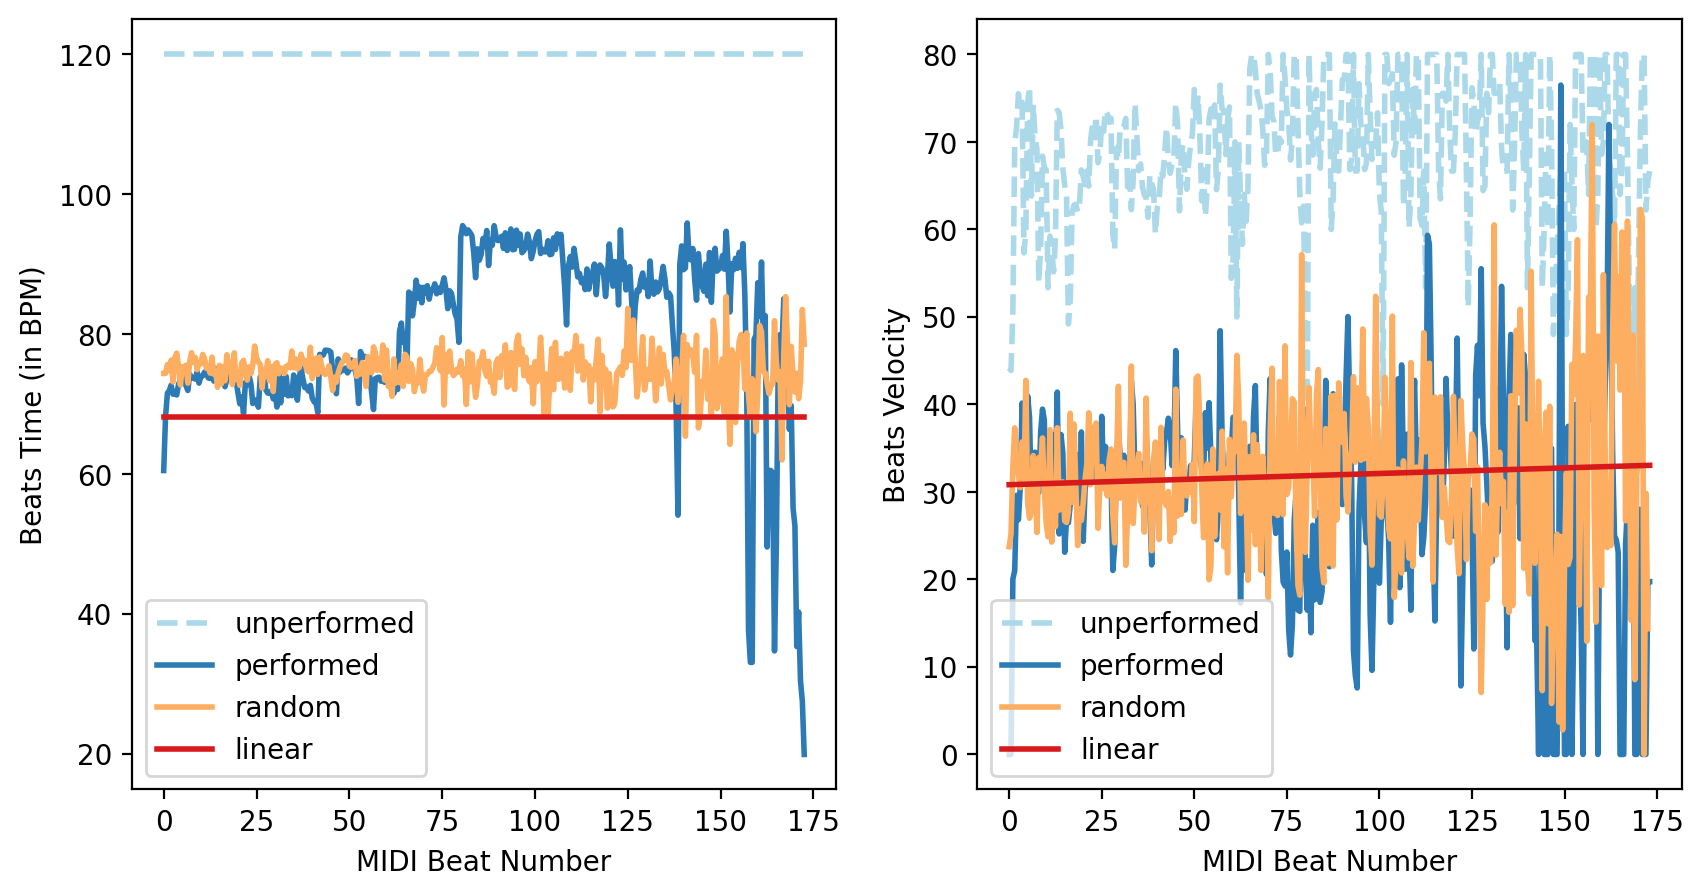

In [11]:
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

warnings.filterwarnings("ignore", category=RuntimeWarning) 


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0] = plot_average_transfer_function(axes[0], midi_beats_list,
                                        midi_beats_list, # unperformed_beats_list
                                        performance_beats_list,
                                        performance_beats_estimated_list_dict,
                                        performance_type="time"
)

axes[1] = plot_average_transfer_function(axes[1], midi_beats_list,
                                        velocity_beats_list, # unperformed_beats_list
                                        perf_velocity_beats_list,
                                        perf_velocity_beats_estimated_list_dict,
                                        performance_type="velocity"
)
plt.savefig("data/task_A.pdf", dpi=600)

# Task B

Use `src.data.get_events_table_from_score`

In [ ]:
from pathlib import Path
# DATASET_PATH = Path("./data/asap-dataset")
# We analyse Bach's Fugues (or other?)
corpus = DATASET_PATH / "Bach" / "Fugue"

# get_average_distribution_given_time_signature(corpus, (3,4))
# get_average_distribution_given_time_signature(corpus, (4,4))
# get_average_distribution_given_time_signature(corpus, (3,8))
get_average_distribution_given_time_signature(corpus, (2,2))

In [ ]:


annotation_path = 'data/asap-dataset/Bach/Fugue/bwv_885/SINKEV06_annotations.txt'

interval = annotation_to_inter_onset_intervals(annotation_path)
beats = extract_time_signatures_from_annotation(annotation_path)[0][1][0]

get_interval_statistics(interval, beats)
get_levene_test_results(interval, beats)

In [ ]:
#df, json = classical()
styles_composers = [baroque_composers, classical_composers, romantic_composers, impressionist_composers, late_russian_composers]
#style_expressiveness_analysis(styles_composers)
result = composer_expressiveness_analysis()
print(result)


In [ ]:
collect_pieces_with_time_signature(corpus, [4,4])